# Lung Disease Diagnosis - Model Tuning

Developer: Tung Nguyen

This notebook contains preliminary classification models for the [lung disease diagnosis dataset](https://www.kaggle.com/datasets/nih-chest-xrays/data).

## Metric Selection
---

The perfect classifier will have zero False Negatives (FN) or False Positives (FP). However, in reality, this is extremely hard to achieve. There are always trade-offs. 

In this case, it is assumed that both False Negatives (FN) and False Positives (FP) have equal weight due to a lack of a use-case for this model. If this were a real deployment, then information about how this model would be used in production could be leveraged to help make modeling and metrics decisions.

* For example, one can argue that FN should be more important than FP in this scenario (e.g. Goal: Minimize FNs) because that would exclude a patient from a treatment that they definitely need. They would be sent home thinking they are healthy. 

* On the other hand, one can argue that FP should be more important than FN because a FP (e.g. Goal: Minimize FPs) because this could potentially cause the patient to purchase and undergo treatment that they did not need. This would waste resources (if the medicine required is rare) as well as cause an undue financial burden on the patient (if the medicine is expensive).

Two popular metrics used to evaluate classification models are the Receiver Operating Characteristics (ROC) Curve and the Precision-Recall (PR) Curve.

The ROC Curve is a plot of the True Positive Rate vs. False Positive Rate of the model for different classification thresholds. Similarly, the PR Curve is a plot of the Precision vs. Recall of the model for different classification thresholds. The area under these curves provide a convenient summary of the model's performance, and allows us to assess the model without having to make a decision on the classification threshold during the training phase (Area = 1 is a perfect classifier). A classification threshold can be chosen at a later stage of the project and can be selected such that the resulting model meets the business-use case (e.g. For the given target True Positive Rate, can you deal with the associated False Positive Rate?).

During the data exploration phase, it was also noted that there is a class imbalance problem present in this dataset. Namely, there are significantly more chest x-ray images with ground truth negative (e.g. no disease present) than there are ground truth positive. This may cause a problem with using the Area Under the ROC Curve (AUROC) as the evaluation metric because calculation of the ROC curve involves True Negatives (e.g. False Positive Rate = FP / (FP + TN)). Since there are large amounts of ground truth negatives in the dataset, AUROC may indicate the model is performing better than it really is. 

Thus, for this project, the Area under the Precision-Recall curve will be the primary model evaluation metric.

## Model Architecture
---



The baseline model for this project will be a VGG16 model, pre-trained on ImageNet images, with a  binary cross entropy loss and the first few layers frozen (set to untrainable). 

Due to time and resource constraints, hyperparameter tuning for this project will be performed on a subset of the dataset.

Models 2 - 8 will experiment with different hyperparameters & configurations to see which have the largest impact. The experiments are detailed in the table below & include things such as:

* Training from scratch vs. fine-tuning

* Data Sampling / Augmentation to combat class imbalance - sample unrepresented classes with transformation (flip, zoom, shifts, etc.)

* No blocks frozen vs. blocks frozen

* Flattening vs. GlobalAvgPooling

* Weighted loss function to combat class imbalance, refer to this [example](https://stackoverflow.com/questions/48485870/multi-label-classification-with-class-weights-in-keras). 

<br>
<br>

__MODEL SUMMARY TABLE__
|  | 1 - Baseline | 2 | 3 | 4 | 5 | 6 | 7 |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Loss | BCE | BCE | BCE | BCE | BCE | Weighted BCE | Weighted BCE |
| Base Model | VGG16 | VGG16 | VGG16 | VGG16 | VGG16 | VGG16 | VGG16 |
| Model Weights | ImageNet | Untrained | ImageNet | ImageNet | ImageNet | ImageNet | ImageNet |
| Data Sampling | Random | Random | Stratified Sampling | Random | Random | Random | Random |
| Blocks Frozen | 1-3 | None | 1-3 | None | 1-3 | 1-3 | None |
| Pooling Operation | Flatten | Flatten | Flatten | Flatten | GlobalAvg2D | Flatten | Flatten |

* BCE = Binary Cross Entropy

## Data Prep
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras import backend as K
from tensorflow import cast, float32

from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../chest-x-ray-data/Data_Entry_2017.csv')
df = df.drop(['OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'], axis=1, inplace=False)

mlb = MultiLabelBinarizer()
lbl_bins = mlb.fit_transform(df['Finding Labels'].str.split("|"))
df_bin = df.join(pd.DataFrame(lbl_bins, columns=mlb.classes_))

with open('../chest-x-ray-data/train_val_list.txt', 'r') as f:
    train_list = f.read().split('\n')

with open('../chest-x-ray-data/test_list.txt', 'r') as f:
    test_list = f.read().split('\n')

df_train_val = df_bin[df_bin['Image Index'].isin(train_list)]
df_test = df_bin[df_bin['Image Index'].isin(test_list)]

df_train, df_val = train_test_split(df_train_val, test_size=0.2, random_state=1)

In [3]:
print(df_train_val.shape)
print(df_train.shape)
print(df_val.shape)
print()
print(df_test.shape)

(86524, 22)
(69219, 22)
(17305, 22)

(25596, 22)


In [4]:
def plot_df_freq(df, labels, title=''):
    df_pos = df[labels].sum()

    ax = df_pos.plot(kind='bar', figsize=(15, 7), rot=20);
    ax.set_title(title);
    ax.set_xlabel('Labels');
    ax.set_ylabel('Frequency');
    ax.bar_label(ax.containers[0])
    
    return df_pos

### Data Sampling

In [5]:
# Random Sampling
sampled_df_train = df_train.sample(20000, random_state=1)

sampled_df_val = df_val.sample(2000, random_state=1)

In [6]:
# Stratified Sampling for Data Augmentation
stratified_sampled_df_train = pd.DataFrame([])

n = 1500

# Sample each label
for lbl in mlb.classes_:
    temp = df_train[df_train[lbl] == 1].sample(
        n,
        replace=True,
        random_state=1
    )
    
    stratified_sampled_df_train = pd.concat([stratified_sampled_df_train, temp])

In [7]:
# Random Oversampling - Method courtesy of https://medium.com/the-owl/imbalanced-multilabel-image-classification-using-keras-fbd8c60d7a4b
oversampled_df_train = sampled_df_train.copy(deep=True)
powercount = {}
powerlabels = np.unique(oversampled_df_train['Finding Labels'])
for p in powerlabels:
    powercount[p] = np.count_nonzero(oversampled_df_train['Finding Labels']==p)

maxcount = np.max(list(powercount.values()))
for p in powerlabels:
    gapnum = maxcount - powercount[p]
    temp_df = sampled_df_train.iloc[np.random.choice(np.where(sampled_df_train['Finding Labels']==p)[0],size=gapnum)]
    oversampled_df_train = oversampled_df_train.append(temp_df, ignore_index=True)

oversampled_df_train.shape

/var/folders/90/kz_5bmj53wlfsbx400_tzyr80000gn/T/ipykernel_8565/4234301935.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  oversampled_df_train = oversampled_df_train.append(temp_df, ignore_index=True)


(4189680, 22)

__Observations__

* Due to the amount of unique combinations of labels, random oversampling is not a feasible approach for this dataset.

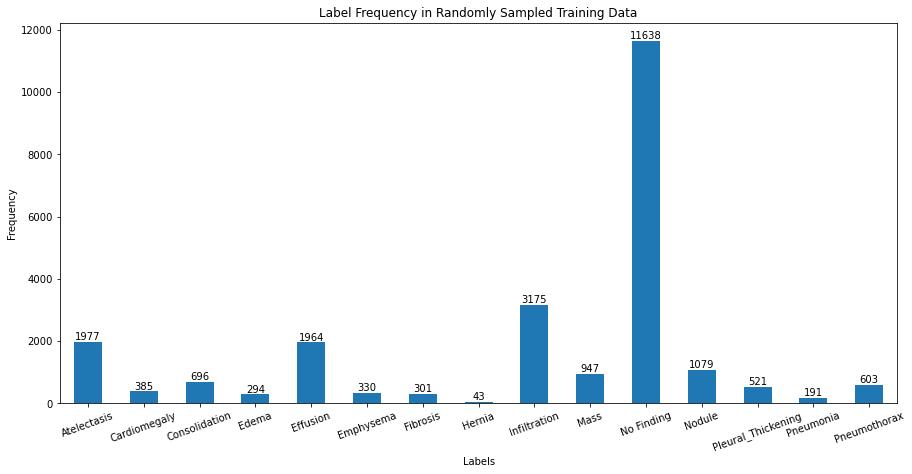

In [7]:
plot_df_freq(sampled_df_train, mlb.classes_, title='Label Frequency in Randomly Sampled Training Data');

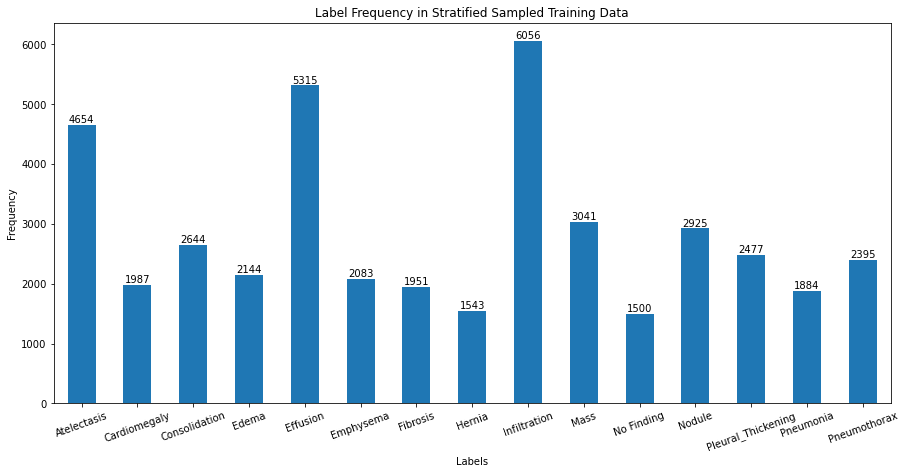

In [8]:
plot_df_freq(stratified_sampled_df_train, mlb.classes_, title='Label Frequency in Stratified Sampled Training Data');

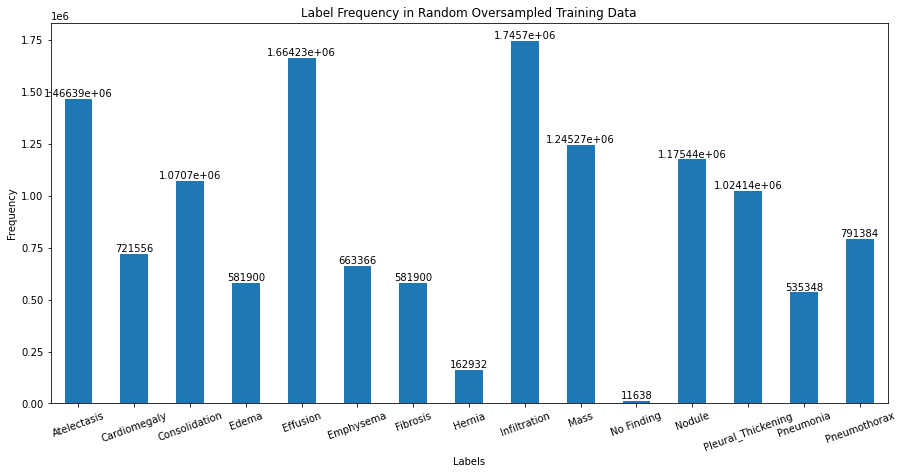

In [10]:
plot_df_freq(oversampled_df_train, mlb.classes_, title='Label Frequency in Random Oversampled Training Data');

### Weighted Loss

In [9]:
labels = [lbl for lbl in mlb.classes_ if lbl != 'No Finding']

In [10]:
weights = []
for i, lbl in enumerate(labels):
    weights.append(dict(enumerate(compute_class_weight(class_weight='balanced', classes=[0., 1.], y=sampled_df_train[lbl]))))
    
# Class Weights
pos = np.array([])
neg = np.array([])
for d in weights:
    pos = np.append(pos, d[1])
    neg = np.append(neg, d[0])

In [11]:
def get_weighted_loss(pos, neg, eps=1e-7):
    def weighted_loss(y_true, y_pred):

        # Cast y_true as float for calculations
        y_true = cast(y_true, float32)

        # Initialize loss
        loss = 0.0

        # Calculate weighted binary cross entropy loss
        for i in range(len(pos)):
            loss += -1 * K.mean(pos[i] * y_true[:, i] * K.log(y_pred[:, i] + eps))
            loss += -1 * K.mean(neg[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + eps))

        return loss
    return weighted_loss

### Helper Functions

In [12]:
def plot_losses(model_history, figsize=(15, 10)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(model_history.history['val_loss'], 'r-o')
    ax.plot(model_history.history['loss'], 'b-o')
    ax.set_title('Training vs. Validation Loss')
    ax.legend(['Validation Loss', 'Training Loss'])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

In [13]:
def datagen_from_df(df, x_col, y_cols, data_dir, preproc_func=None, target_size=(256, 256), shuffle=False, batch_size=64, color_mode='rgb', random_state=1):

    datagen = ImageDataGenerator(
        preprocessing_function=preproc_func,
        horizontal_flip=True,
        vertical_flip=False,
        height_shift_range=0.05,
        width_shift_range=0.1,
        rotation_range=5,
        shear_range=0.1,
        fill_mode='reflect',
        zoom_range=0.15,
    )

    img_generator = datagen.flow_from_dataframe(
        df,
        data_dir,
        shuffle=shuffle,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        seed=random_state
    )

    return img_generator

In [14]:
# Base Models
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
)

untrained_base_model = VGG16(
    include_top=False,
    weights=None,
    input_shape=(256, 256, 3)
)

# Callbacks
early = EarlyStopping(
    monitor="val_loss",
    mode="min", 
    patience=8
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=4, 
    min_lr=0.0000001
)

chkpt = {}    
base_path = './models/'

for i in np.arange(1, 9):

    chkpt[i] = ModelCheckpoint(
        base_path + 'model-' + str(i) + '.h5', 
        monitor='val_loss',
        verbose=1, 
        save_best_only=True, 
        mode='min', 
    )

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-06-03 21:33:01.419995: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-03 21:33:01.420346: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Models
---

### DataGenerators

In [15]:
data_dir = '../chest-x-ray-data/imgs/'

In [16]:
train_gen = {}
val_gen = {}
for i in np.arange(1, 8):
    train_gen[i] = datagen_from_df(
        sampled_df_train, 
        x_col = 'Image Index', 
        y_cols = labels, 
        data_dir = data_dir, 
        preproc_func = preprocess_input, 
        target_size = (256, 256), 
        shuffle=True,
        batch_size = 64, 
        color_mode = 'rgb', 
        random_state = 1
        )

    val_gen[i] = datagen_from_df(
        sampled_df_val, 
        x_col = 'Image Index', 
        y_cols = labels, 
        data_dir = data_dir, 
        preproc_func = preprocess_input, 
        target_size = (256, 256), 
        shuffle=False,
        batch_size = 64, 
        color_mode = 'rgb', 
        random_state = 1
        )

# Model 3 is the only one which uses stratified sampling df - overwrite
train_gen[3] = datagen_from_df(
    stratified_sampled_df_train, 
    x_col = 'Image Index', 
    y_cols = labels, 
    data_dir = data_dir, 
    preproc_func = preprocess_input, 
    target_size = (256, 256), 
    shuffle=True, 
    batch_size = 64, 
    color_mode = 'rgb', 
    random_state = 1
    )

Found 20000 validated image filenames.
Found 2000 validated image filenames.
Found 20000 validated image filenames.
Found 2000 validated image filenames.
Found 20000 validated image filenames.
Found 2000 validated image filenames.
Found 20000 validated image filenames.
Found 2000 validated image filenames.
Found 20000 validated image filenames.
Found 2000 validated image filenames.
Found 20000 validated image filenames.
Found 2000 validated image filenames.
Found 20000 validated image filenames.
Found 2000 validated image filenames.
Found 22500 validated image filenames.


In [21]:
history = {}

### Model 1 - Baseline

In [22]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    if any(x in layer.name for x in ['block1', 'block2', 'block3']):
        layer.trainable = False
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [23]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [24]:
m = 1

history[m] = model.fit(
    train_gen[m], 
    validation_data=val_gen[m],
    epochs = 40,
    callbacks = [chkpt[m], early, reduce_lr]
)

Epoch 1/40


2022-06-03 21:42:47.287901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 0.1726 - auc_2: 0.0532 - auc_3: 0.5465

2022-06-03 21:48:09.291249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from 0.16242 to 0.16011, saving model to ./models/model-1.h5
313/313 [==============================] - 355s 1s/step - loss: 0.1726 - auc_2: 0.0532 - auc_3: 0.5465 - val_loss: 0.1601 - val_auc_2: 0.0614 - val_auc_3: 0.5985 - lr: 0.0010
Epoch 2/40
313/313 [==============================] - ETA: 0s - loss: 0.1625 - auc_2: 0.0654 - auc_3: 0.5965
Epoch 2: val_loss improved from 0.16011 to 0.15697, saving model to ./models/model-1.h5
313/313 [==============================] - 356s 1s/step - loss: 0.1625 - auc_2: 0.0654 - auc_3: 0.5965 - val_loss: 0.1570 - val_auc_2: 0.0730 - val_auc_3: 0.6152 - lr: 0.0010
Epoch 3/40
313/313 [==============================] - ETA: 0s - loss: 0.1587 - auc_2: 0.0738 - auc_3: 0.6284
Epoch 3: val_loss improved from 0.15697 to 0.15370, saving model to ./models/model-1.h5
313/313 [==============================] - 443s 1s/step - loss: 0.1587 - auc_2: 0.0738 - auc_3: 0.6284 - val_loss: 0.1537 - val_auc_2: 0.0836 - val_auc_3: 0.6511 - lr:

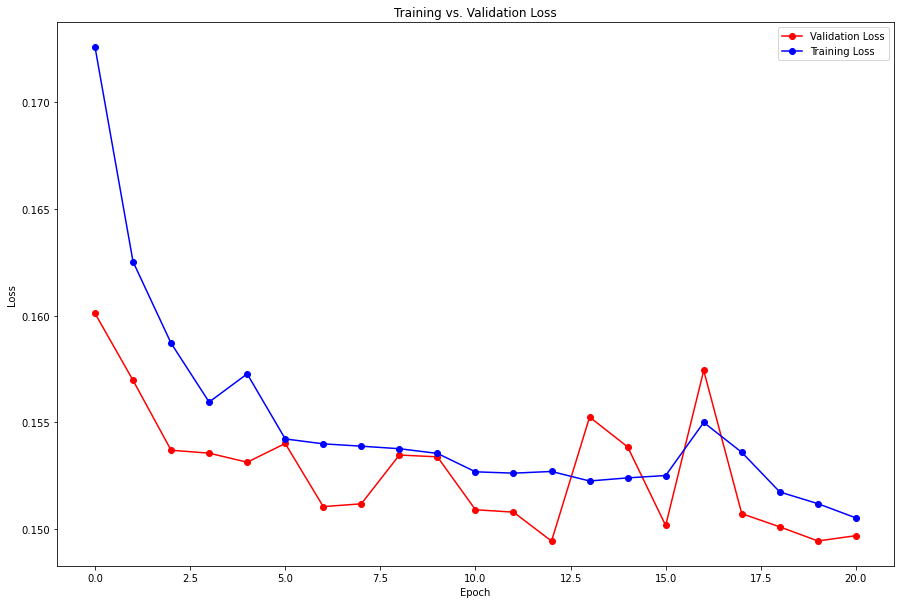

In [25]:
plot_losses(history[1])

### Model 2

In [26]:
model = Sequential()

for layer in untrained_base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [27]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [28]:
m = 2

history[m] = model.fit(
    train_gen[m], 
    validation_data=val_gen[m],
    epochs = 40,
    callbacks = [chkpt[m], early, reduce_lr]
)

Epoch 1/40


2022-06-04 00:23:03.025917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 0.2521 - auc_4: 0.0465 - auc_5: 0.5086

2022-06-04 00:30:43.175643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.16201, saving model to ./models/model-2.h5
313/313 [==============================] - 492s 2s/step - loss: 0.2521 - auc_4: 0.0465 - auc_5: 0.5086 - val_loss: 0.1620 - val_auc_4: 0.0545 - val_auc_5: 0.5421 - lr: 0.0010
Epoch 2/40
313/313 [==============================] - ETA: 0s - loss: 0.1634 - auc_4: 0.0555 - auc_5: 0.5468
Epoch 2: val_loss improved from 0.16201 to 0.15994, saving model to ./models/model-2.h5
313/313 [==============================] - 487s 2s/step - loss: 0.1634 - auc_4: 0.0555 - auc_5: 0.5468 - val_loss: 0.1599 - val_auc_4: 0.0617 - val_auc_5: 0.5787 - lr: 0.0010
Epoch 3/40
313/313 [==============================] - ETA: 0s - loss: 0.1612 - auc_4: 0.0637 - auc_5: 0.5792
Epoch 3: val_loss improved from 0.15994 to 0.15814, saving model to ./models/model-2.h5
313/313 [==============================] - 487s 2s/step - loss: 0.1612 - auc_4: 0.0637 - auc_5: 0.5792 - val_loss: 0.1581 - val_auc_4: 0.0657 - val_auc_5: 0.5865 - lr: 0.0

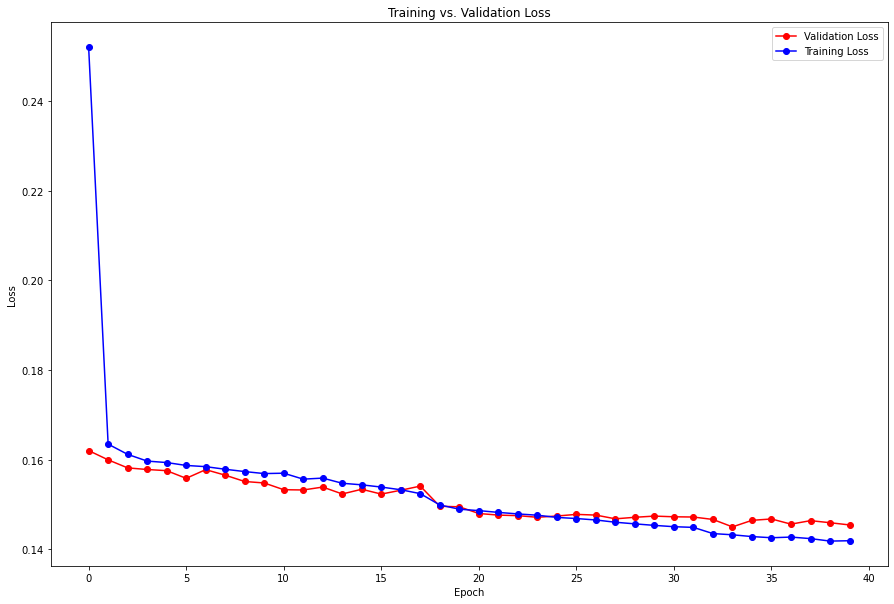

In [29]:
plot_losses(history[2])

### Model 3

In [30]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    if any(x in layer.name for x in ['block1', 'block2', 'block3']):
        layer.trainable = False
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [31]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [32]:
m = 3

history[m] = model.fit(
    train_gen[m], 
    validation_data=val_gen[m],
    epochs = 40,
    callbacks = [chkpt[m], early, reduce_lr]
)

Epoch 1/40


2022-06-04 05:47:48.026733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


352/352 [==============================] - ETA: 0s - loss: 0.3633 - auc_6: 0.1865 - auc_7: 0.6215

2022-06-04 05:53:43.007112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.19070, saving model to ./models/model-3.h5
352/352 [==============================] - 387s 1s/step - loss: 0.3633 - auc_6: 0.1865 - auc_7: 0.6215 - val_loss: 0.1907 - val_auc_6: 0.0963 - val_auc_7: 0.6815 - lr: 0.0010
Epoch 2/40
352/352 [==============================] - ETA: 0s - loss: 0.3524 - auc_6: 0.2191 - auc_7: 0.6605
Epoch 2: val_loss improved from 0.19070 to 0.18640, saving model to ./models/model-3.h5
352/352 [==============================] - 383s 1s/step - loss: 0.3524 - auc_6: 0.2191 - auc_7: 0.6605 - val_loss: 0.1864 - val_auc_6: 0.0966 - val_auc_7: 0.7007 - lr: 0.0010
Epoch 3/40
352/352 [==============================] - ETA: 0s - loss: 0.3496 - auc_6: 0.2323 - auc_7: 0.6724
Epoch 3: val_loss improved from 0.18640 to 0.18440, saving model to ./models/model-3.h5
352/352 [==============================] - 380s 1s/step - loss: 0.3496 - auc_6: 0.2323 - auc_7: 0.6724 - val_loss: 0.1844 - val_auc_6: 0.1007 - val_auc_7: 0.7068 - lr: 0.0

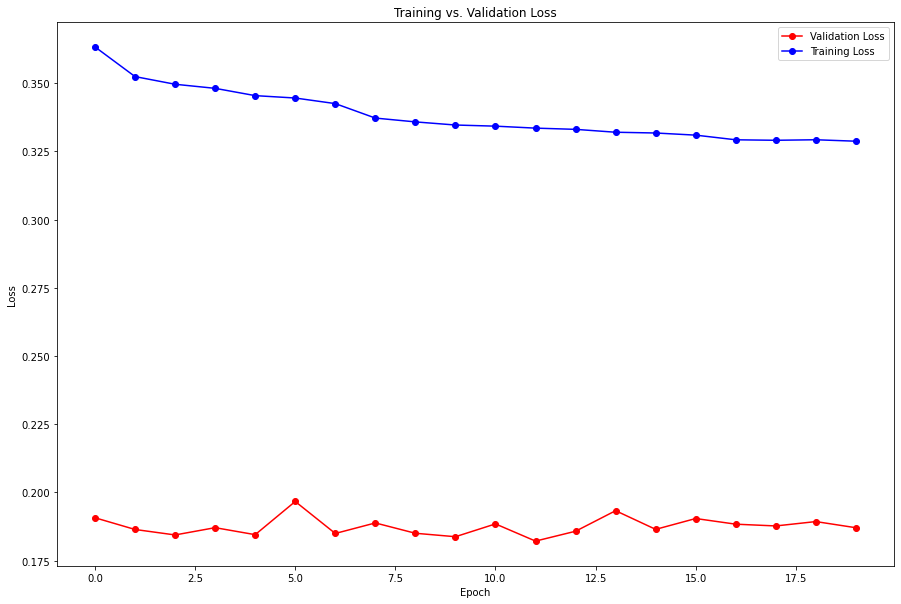

In [33]:
plot_losses(history[3])

### Model 4

In [34]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [35]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [36]:
m = 4

history[m] = model.fit(
    train_gen[m], 
    validation_data=val_gen[m],
    epochs = 40,
    callbacks = [chkpt[m], early, reduce_lr]
)

Epoch 1/40


2022-06-04 07:55:03.733538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 0.1805 - auc_8: 0.0465 - auc_9: 0.5061

2022-06-04 08:02:45.380534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.16292, saving model to ./models/model-4.h5
313/313 [==============================] - 494s 2s/step - loss: 0.1805 - auc_8: 0.0465 - auc_9: 0.5061 - val_loss: 0.1629 - val_auc_8: 0.0499 - val_auc_9: 0.5269 - lr: 0.0010
Epoch 2/40
313/313 [==============================] - ETA: 0s - loss: 0.1657 - auc_8: 0.0477 - auc_9: 0.5082
Epoch 2: val_loss improved from 0.16292 to 0.16193, saving model to ./models/model-4.h5
313/313 [==============================] - 487s 2s/step - loss: 0.1657 - auc_8: 0.0477 - auc_9: 0.5082 - val_loss: 0.1619 - val_auc_8: 0.0520 - val_auc_9: 0.5349 - lr: 0.0010
Epoch 3/40
313/313 [==============================] - ETA: 0s - loss: 0.1631 - auc_8: 0.0538 - auc_9: 0.5495
Epoch 3: val_loss improved from 0.16193 to 0.16100, saving model to ./models/model-4.h5
313/313 [==============================] - 487s 2s/step - loss: 0.1631 - auc_8: 0.0538 - auc_9: 0.5495 - val_loss: 0.1610 - val_auc_8: 0.0576 - val_auc_9: 0.5570 - lr: 0.0

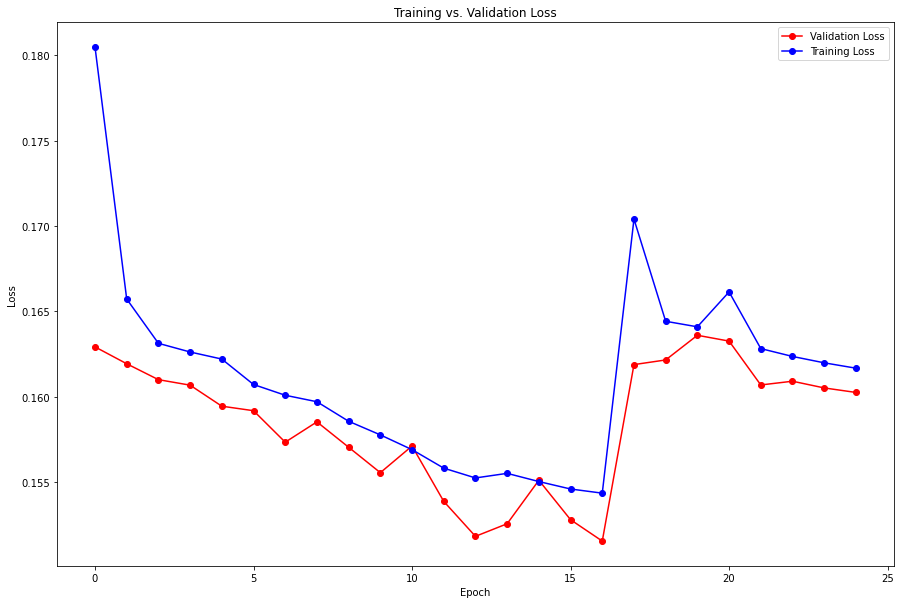

In [37]:
plot_losses(history[4])

### Model 5

In [38]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    if any(x in layer.name for x in ['block1', 'block2', 'block3']):
        layer.trainable = False
    
model.add(GlobalAveragePooling2D())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [39]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [40]:
m = 5

history[m] = model.fit(
    train_gen[m], 
    validation_data=val_gen[m],
    epochs = 40,
    callbacks = [chkpt[m], early, reduce_lr]
)

Epoch 1/40


2022-06-04 11:19:24.899289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 0.2065 - auc_10: 0.0505 - auc_11: 0.5399

2022-06-04 11:24:39.800055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.16652, saving model to ./models/model-5.h5
313/313 [==============================] - 347s 1s/step - loss: 0.2065 - auc_10: 0.0505 - auc_11: 0.5399 - val_loss: 0.1665 - val_auc_10: 0.0572 - val_auc_11: 0.5434 - lr: 0.0010
Epoch 2/40
313/313 [==============================] - ETA: 0s - loss: 0.1651 - auc_10: 0.0565 - auc_11: 0.5621
Epoch 2: val_loss improved from 0.16652 to 0.16248, saving model to ./models/model-5.h5
313/313 [==============================] - 343s 1s/step - loss: 0.1651 - auc_10: 0.0565 - auc_11: 0.5621 - val_loss: 0.1625 - val_auc_10: 0.0596 - val_auc_11: 0.5494 - lr: 0.0010
Epoch 3/40
313/313 [==============================] - ETA: 0s - loss: 0.1628 - auc_10: 0.0598 - auc_11: 0.5697
Epoch 3: val_loss improved from 0.16248 to 0.16084, saving model to ./models/model-5.h5
313/313 [==============================] - 343s 1s/step - loss: 0.1628 - auc_10: 0.0598 - auc_11: 0.5697 - val_loss: 0.1608 - val_auc_10: 0.0597 - val_auc_11: 

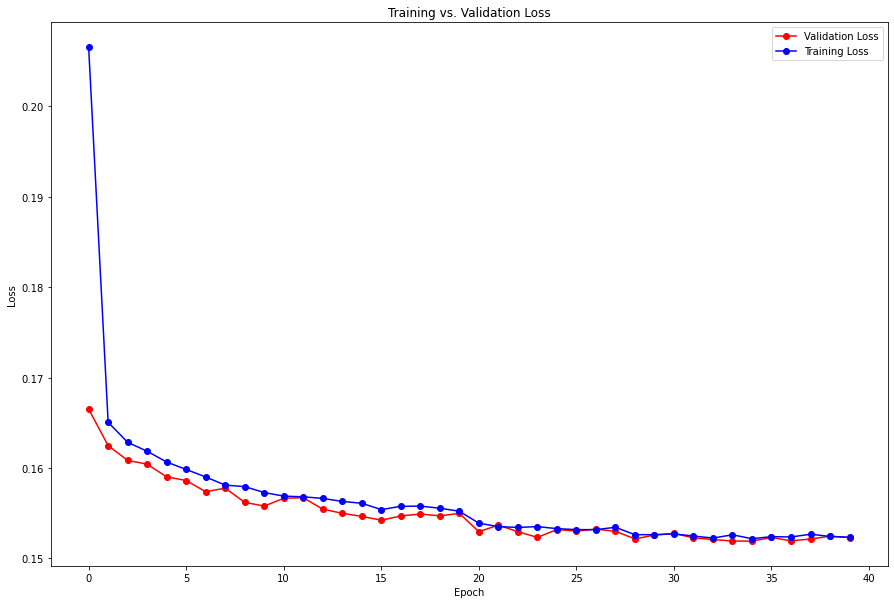

In [41]:
plot_losses(history[5])

### Model 6

In [42]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    if any(x in layer.name for x in ['block1', 'block2', 'block3']):
        layer.trainable = False
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [43]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg),
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [44]:
m = 6

history[m] = model.fit(
    train_gen[m], 
    validation_data=val_gen[m],
    epochs = 40,
    callbacks = [chkpt[m], early, reduce_lr]
)

Epoch 1/40


2022-06-04 15:08:00.583628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 9.8656 - auc_12: 0.0556 - auc_13: 0.5634

2022-06-04 15:13:16.083194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 9.47988, saving model to ./models/model-6.h5
313/313 [==============================] - 349s 1s/step - loss: 9.8656 - auc_12: 0.0556 - auc_13: 0.5634 - val_loss: 9.4799 - val_auc_12: 0.0586 - val_auc_13: 0.5943 - lr: 0.0010
Epoch 2/40
313/313 [==============================] - ETA: 0s - loss: 9.6978 - auc_12: 0.0572 - auc_13: 0.5649
Epoch 2: val_loss did not improve from 9.47988
313/313 [==============================] - 346s 1s/step - loss: 9.6978 - auc_12: 0.0572 - auc_13: 0.5649 - val_loss: 9.6242 - val_auc_12: 0.0441 - val_auc_13: 0.4941 - lr: 0.0010
Epoch 3/40
313/313 [==============================] - ETA: 0s - loss: 9.7170 - auc_12: 0.0446 - auc_13: 0.4975
Epoch 3: val_loss did not improve from 9.47988
313/313 [==============================] - 345s 1s/step - loss: 9.7170 - auc_12: 0.0446 - auc_13: 0.4975 - val_loss: 9.6017 - val_auc_12: 0.0487 - val_auc_13: 0.5204 - lr: 0.0010
Epoch 4/40
313/313 [==============================] - ETA: 0s 

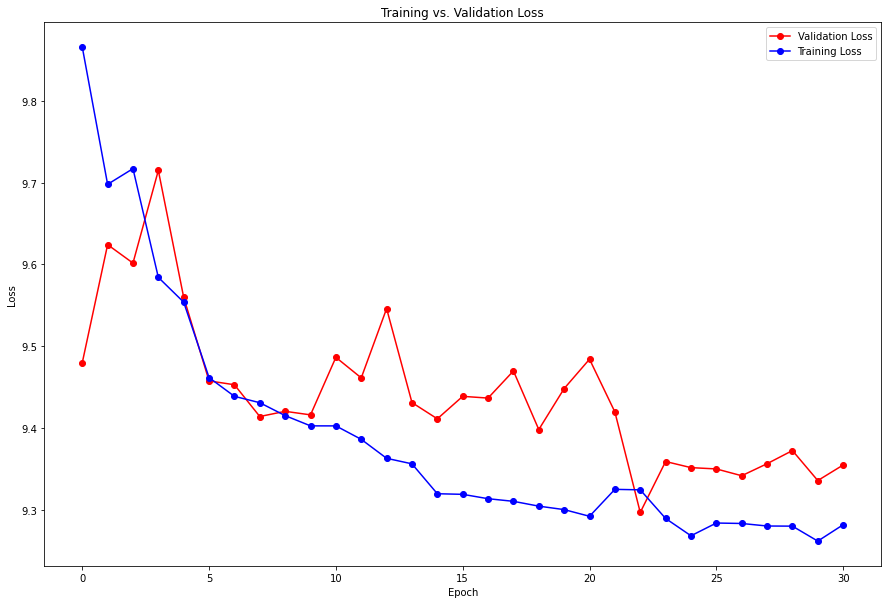

In [45]:
plot_losses(history[6])

### Model 7

In [46]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [47]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg),
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [48]:
m = 7

history[m] = model.fit(
    train_gen[m], 
    validation_data=val_gen[m],
    epochs = 40,
    callbacks = [chkpt[m], early, reduce_lr]
)

Epoch 1/40


2022-06-04 18:06:50.701144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 9.7243 - auc_14: 0.0458 - auc_15: 0.5011

2022-06-04 18:14:31.504313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 9.59836, saving model to ./models/model-7.h5
313/313 [==============================] - 494s 2s/step - loss: 9.7243 - auc_14: 0.0458 - auc_15: 0.5011 - val_loss: 9.5984 - val_auc_14: 0.0440 - val_auc_15: 0.5000 - lr: 0.0010
Epoch 2/40
313/313 [==============================] - ETA: 0s - loss: 9.7055 - auc_14: 0.0439 - auc_15: 0.4898
Epoch 2: val_loss improved from 9.59836 to 9.59829, saving model to ./models/model-7.h5
313/313 [==============================] - 488s 2s/step - loss: 9.7055 - auc_14: 0.0439 - auc_15: 0.4898 - val_loss: 9.5983 - val_auc_14: 0.0440 - val_auc_15: 0.5000 - lr: 0.0010
Epoch 3/40
313/313 [==============================] - ETA: 0s - loss: 9.7055 - auc_14: 0.0441 - auc_15: 0.4909
Epoch 3: val_loss did not improve from 9.59829
313/313 [==============================] - 488s 2s/step - loss: 9.7055 - auc_14: 0.0441 - auc_15: 0.4909 - val_loss: 9.5985 - val_auc_14: 0.0440 - val_auc_15: 0.5000 - lr: 0.0010
Epoch 4/40
313/313 [=

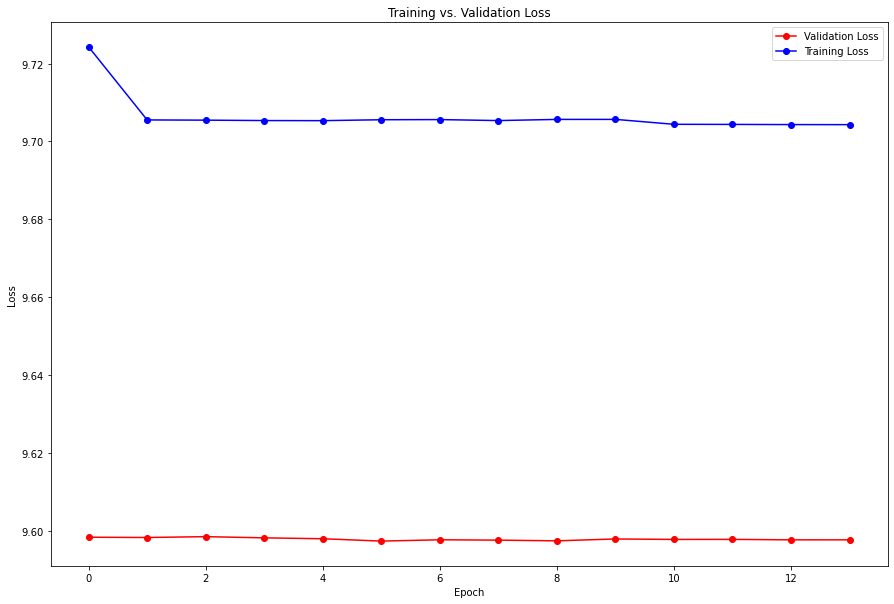

In [49]:
plot_losses(history[7])

## Model Evaluation
---

In [50]:
import csv
from tensorflow.keras.models import load_model

In [51]:
def plot_roc_auc(y_true, y_pred, labels, model_name, file_path, csv_writer, figsize=(15, 10)):
    
    csv_writer.writerow(['label', 'fpr', 'tpr', 'threshold'])
    areas = {}

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred[:, i])
        areas[lbl] = auc(fpr, tpr)
        ax.plot(fpr, tpr, label = 'Score = %s (AUC: %0.5f)'  % (lbl, areas[lbl]))
        csv_writer.writerows(zip([lbl] * len(fpr), fpr, tpr, thresholds))

    ax.legend()
    ax.set_title('ROC Curves - ' + model_name);
    ax.set_xlabel('False Positive Rate (FPR)');
    ax.set_ylabel('True Positive Rate (TPR)');
    fig.savefig(file_path)
    plt.close(fig)

    return areas

def plot_precision_recall_auc(y_true, y_pred, labels, model_name, file_path, csv_writer, figsize=(15, 10)):

    csv_writer.writerow(['pr', 'rc', 'threshold'])
    areas = {}

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        pr, rc, thresholds = precision_recall_curve(y_true[:, i], y_pred[:, i])
        areas[lbl] = auc(rc, pr)
        ax.plot(rc, pr, label = 'Score = %s (AUC: %0.5f)'  % (lbl, areas[lbl]))
        csv_writer.writerows(zip([lbl] * len(pr), pr, rc, thresholds))

    ax.legend()
    ax.set_title('Precision-Recall Curve - ' + model_name);
    ax.set_xlabel('Recall');
    ax.set_ylabel('Precision');
    fig.savefig(file_path)
    plt.close(fig)

    return areas

In [52]:
for i in np.arange(1, 8):
    model_name = 'model-' + str(i)

    roc_jpg = './results/roc-' + model_name + '.jpg'
    roc_csv = './results/roc-' + model_name + '.csv'
    auroc_csv = './results/auroc-' + model_name + '.csv'
    pr_jpg = './results/pr-' + model_name + '.jpg'
    pr_csv = './results/pr-' + model_name + '.csv'
    aupr_csv= './results/aupr-' + model_name + '.csv'
    
    model = load_model('./models/' + model_name + '.h5', compile=False)

    val_gen[i].reset()
    y_true = val_gen[i].labels
    y_pred = model.predict(val_gen[i], batch_size=64, verbose=True)

    with open(roc_csv, 'w') as f:
        csv_writer = csv.writer(f)
        areas = plot_roc_auc(y_true, y_pred, labels, model_name, roc_jpg, csv_writer, figsize=(15, 10))
    
    with open(auroc_csv, 'w') as f:
        dict_writer = csv.DictWriter(f, fieldnames=labels)
        dict_writer.writeheader()
        dict_writer.writerow(areas)

    with open(pr_csv, 'w') as f:
        csv_writer = csv.writer(f)
        areas = plot_precision_recall_auc(y_true, y_pred, labels, model_name, pr_jpg, csv_writer, figsize=(15, 10))

    with open(aupr_csv, 'w') as f:
        dict_writer = csv.DictWriter(f, fieldnames=labels)
        dict_writer.writeheader()
        dict_writer.writerow(areas)

2022-06-05 19:19:34.507208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 32s 986ms/step


2022-06-05 19:20:07.653555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 31s 965ms/step


2022-06-05 19:20:40.053659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 31s 961ms/step


2022-06-05 19:21:12.296161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 31s 963ms/step


2022-06-05 19:21:44.689410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 31s 962ms/step


2022-06-05 19:22:17.075913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 31s 962ms/step


2022-06-05 19:22:49.447056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 31s 961ms/step


For reference, the model summary table from the beginning of the notebook is copied below.

<br>

__MODEL SUMMARY TABLE__
|  | 1 - Baseline | 2 | 3 | 4 | 5 | 6 | 7 |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Loss | BCE | BCE | BCE | BCE | BCE | Weighted BCE | Weighted BCE |
| Base Model | VGG16 | VGG16 | VGG16 | VGG16 | VGG16 | VGG16 | VGG16 |
| Model Weights | ImageNet | Untrained | ImageNet | ImageNet | ImageNet | ImageNet | ImageNet |
| Data Sampling | Random | Random | Stratified Sampling | Random | Random | Random | Random |
| Blocks Frozen | 1-3 | None | 1-3 | None | 1-3 | 1-3 | None |
| Pooling Operation | Flatten | Flatten | Flatten | Flatten | GlobalAvg2D | Flatten | Flatten |

* BCE = Binary Cross Entropy

### Area Under ROC Curve

In [53]:
import os

def highlight_max(s, props=''):
    return np.where(s == np.max(s.values), props, '')

def highlight_min(s, props=''):
    return np.where(s == np.min(s.values), props, '')

results_dir = r'./results/'
csv_files = sorted([x for x in os.listdir(results_dir) if 'csv' in x and 'auroc' in x])

df_list = [pd.read_csv(results_dir + file).assign(File=file) for file in csv_files]

df = pd.concat(df_list, ignore_index=True)
df = df.set_index('File')
df = df.transpose()

df.style.apply(
    highlight_max, props='color:darkgreen;background-color:lightgreen', axis=1
        ).apply(
    highlight_min, props='color:darkred;background-color:salmon', axis=1
        ).set_caption('SUMMARY - Area Under ROC Curve')

File,auroc-model-1.csv,auroc-model-2.csv,auroc-model-3.csv,auroc-model-4.csv,auroc-model-5.csv,auroc-model-6.csv,auroc-model-7.csv
Atelectasis,0.702118,0.723808,0.701123,0.696858,0.709432,0.637684,0.500000
Cardiomegaly,0.598420,0.784200,0.627678,0.607695,0.573174,0.602637,0.500000
Consolidation,0.773982,0.764722,0.798216,0.746203,0.741791,0.658838,0.500000
Edema,0.814848,0.883571,0.866344,0.824819,0.820307,0.674177,0.500000
Effusion,0.842635,0.839346,0.842761,0.814995,0.795491,0.655274,0.500000
Emphysema,0.711032,0.598359,0.753283,0.633503,0.660897,0.492538,0.500000
Fibrosis,0.686561,0.679107,0.669490,0.690034,0.622602,0.582349,0.500000
Hernia,0.791354,0.945752,0.905692,0.533801,0.908029,0.766984,0.500000
Infiltration,0.634464,0.670350,0.615125,0.632026,0.634433,0.600558,0.500000
Mass,0.648182,0.732572,0.635370,0.594927,0.615972,0.438827,0.500000


__Observations__

* Green-colored cell = best performing model for the given label

* Red-colored cell = worst performing model for the given label

* As shown in the dataframe above, all models (6 & 7) with the weighted loss did not perform very well. In model-7, the model does not seem to be learning.

In [55]:
print('Average AUROC:')
for ind, col in df_drop.iteritems():
    print('%s: %0.6f' % (ind, col.mean()))

Average AUROC:
auroc-model-1.csv: 0.708466
auroc-model-2.csv: 0.744168
auroc-model-3.csv: 0.715501
auroc-model-4.csv: 0.660440
auroc-model-5.csv: 0.674549


__Observations__

* All models were able to achieve an AUROC of around ~0.7. However, as discussed above, AUROC is overly optimistic for the problem at hand due to the inclusion of FNs in the calculation.

* model-2 performed the best (both on average & in terms of number of green cells). model-1 and model-3 are not far behind.

* The ROC Curves for model 1 (baseline model) is shown below.

![image](./results/roc-model-1.jpg)

### Area Under PR Curve

In [66]:
csv_files = sorted([x for x in os.listdir(results_dir) if 'csv' in x and 'aupr' in x])

df_list = [pd.read_csv(results_dir + file).assign(File=file) for file in csv_files]

df = pd.concat(df_list, ignore_index=True)
df = df.set_index('File')
df = df.transpose()

# model-7 is erroneous, thus, is removed from this assessment.
df_drop = df.drop('aupr-model-7.csv', axis=1)

df_drop.style.apply(
    highlight_max, props='color:darkgreen;background-color:lightgreen', axis=1
        ).apply(
    highlight_min, props='color:darkred;background-color:salmon', axis=1
        ).set_caption("SUMMARY - Area Under PR Curve")

File,aupr-model-1.csv,aupr-model-2.csv,aupr-model-3.csv,aupr-model-4.csv,aupr-model-5.csv,aupr-model-6.csv
Atelectasis,0.163996,0.208453,0.188021,0.190985,0.181487,0.124074
Cardiomegaly,0.029388,0.099773,0.034887,0.034422,0.026664,0.035608
Consolidation,0.133307,0.116111,0.121504,0.087189,0.092257,0.059008
Edema,0.066418,0.154025,0.107548,0.081605,0.092446,0.032207
Effusion,0.362956,0.462039,0.379477,0.315252,0.307007,0.161078
Emphysema,0.039089,0.022377,0.075734,0.023995,0.024209,0.013646
Fibrosis,0.026073,0.027248,0.028627,0.050686,0.028503,0.053506
Hernia,0.003327,0.034359,0.095646,0.001482,0.007516,0.003624
Infiltration,0.245505,0.264793,0.244522,0.245339,0.265377,0.234943
Mass,0.096686,0.130011,0.078362,0.081518,0.088850,0.034478


In [68]:
print('Average AUPR:')
for ind, col in df_drop.iteritems():
    print('%s: %0.6f' % (ind, col.mean()))

Average AUPR:
aupr-model-1.csv: 0.100980
aupr-model-2.csv: 0.124037
aupr-model-3.csv: 0.116620
aupr-model-4.csv: 0.091203
aupr-model-5.csv: 0.089583
aupr-model-6.csv: 0.063659


__Observations__

* The AUPR is a much less optimistic evaluation of the models, with most models hovering around an average AUPR = 0.1

* The conclusions from AUPR is the same for AUROC: model 1, 2, 3 are the best performing models, whereas model 4-7 do not perform that well.

* Insights gained from model-4 and model-5:

    * model-4: Baseline VGG16 + Initial Layers Unfrozen. It is generally known that the initial layers of a DNN contain lower-order features learned by the model. When unfreezing these layers from a pretrained model, it alters these lower-end features and diminishes the benefit of the pre-training step. 

    * model-5: Baseline VGG16 + GlobalAvg2D. A Flatten layer results in more parameters. While a GlobalAvg2D layer is more computationallly efficient, model-5 may be losing information.

The PR curve for model-1 is shown below.

![image](./results/pr-model-1.jpg)